In [1]:
import sys
import time
from pprint import pformat

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
%matplotlib inline

from geodesic_agent import GeodesicAgent
from gridworld import Arena, Bottleneck, LinearChamber
from plot_utils import plot_replay, plot_traj, plot_need_gain
from RL_utils import oned_twod

def dict_print(d, indent_size=1):
    '''
        Fancy printing. Collapse identical, consecutive rows in input dictionary d.
    '''
    indent = ' ' * indent_size
    for kdx, key in enumerate(d.keys()):
        val = d[key]
        if kdx == 0: # No previous one to compare to
            prev_val = val
            start = kdx
            continue
        
        if val == prev_val: # Consecutive, skip
            continue
        
        # Non-consecutive, print out
        if kdx - 1 == start:
            print_key = '%d' % start
        else:
            print_key = '%d-%d' % (start, kdx - 1)
        
        print(indent + '%s: %s' % (print_key, prev_val))
        
        # Update
        start = kdx
        prev_val = val
    
    if kdx - 1 == start:
        print_key = '%d' % start
    else:
        print_key = '%d-%d' % (start, kdx - 1)

    print(indent + '%s: %s' % (print_key, prev_val))

*Open field*

In [2]:
# Physics
width = 10
height = 7
num_states = width * height

# Build object
one_start_state = np.zeros(num_states)
one_start_state[0] = 1
all_start_states = np.ones(num_states) / num_states

init_state_dist = all_start_states
arena = Arena(width, height, init_state_distribution=init_state_dist)
all_experiences = arena.get_all_transitions()
T = arena.transitions

## Agent parameters
corner_goals = np.array([width - 1, (height - 1) * width, height * width - 1]) # Non-start corners
all_goals = np.arange(0, width * height)

goals = all_goals
alpha = 1.0
gamma = 0.95
num_replay_steps = 50

# Set up agent
ga = GeodesicAgent(arena.num_states, arena.num_actions, goals, T, alpha=alpha, gamma=gamma,
                   s0_dist=init_state_dist)
ga.curr_state = 0
ga.remember(all_experiences) # Pre-load our agent with all possible memories

## Run replay
replayed_experiences, stats_for_nerds, backups = ga.replay(num_steps=num_replay_steps, verbose=True, prospective=True)
needs, gains, all_MEVBs = stats_for_nerds

First 50 replay steps


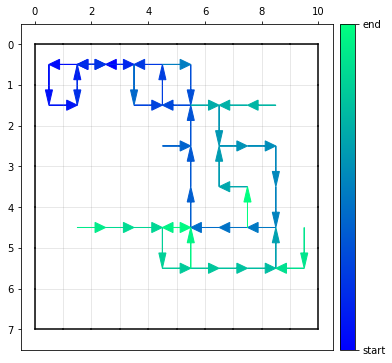

step 0:


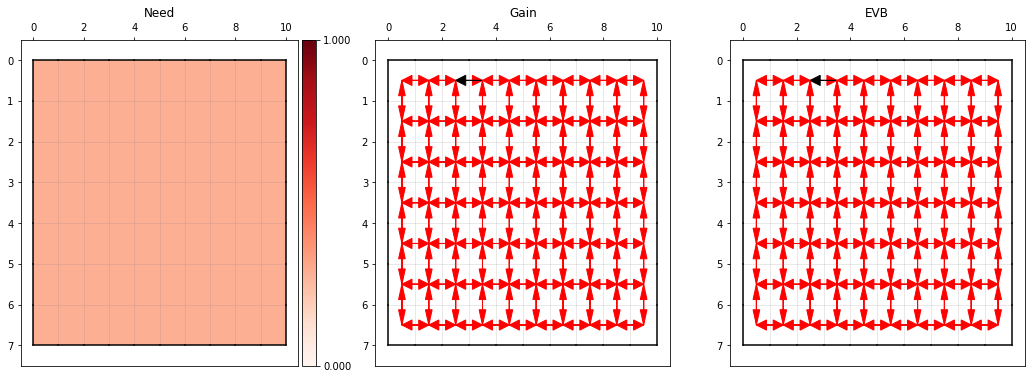

step 1:


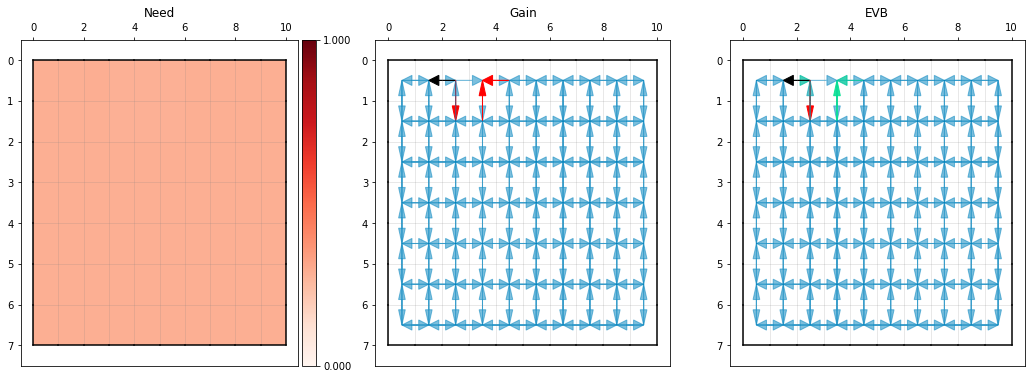

step 2:


KeyboardInterrupt: 

In [4]:
# Plot the replayed experiences
print('First %d replay steps' % num_replay_steps, flush=True)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_replay(arena, np.array(replayed_experiences).astype(int), ax=ax)
plt.show()

# Plotting params
params = {'min_need' : 0,
          'max_need' : 1}

# Plot need, gain, MEVB throughout each of those steps
meta_need = np.mean(needs, axis=1)
meta_gain = np.mean(gains, axis=1)
meta_MEVB = np.mean(all_MEVBs, axis=1)
verbose = False

for i in range(num_replay_steps):
    print('step %d:' % i)
    if verbose:
        print('\tReplayed transition:', replayed_experiences[i])
        print('\tBackup dictionary:')
        dict_print(backups[i], indent_size=8)
        print('\tReplay history:')
        for j in range(i):
            print('\t\t',replayed_experiences[j]) # so dumb

    plot_need_gain(arena, ga.memory, np.average(meta_need[i, :, :], weights=init_state_dist, axis=0), 
                   meta_gain[i, :], meta_MEVB[i, :], specials=[tuple(replayed_experiences[i])], params=params)
    plt.show()

*Bottleneck chamber*

In [ ]:
## Bottleneck
# Physics
room_width = 1
corridor_width = 4
width = room_width * 2 + corridor_width
height = 5
num_states = width * height

# Build object
init_state_dist = np.ones(num_states) / num_states
bottleneck = Bottleneck(room_width, corridor_width, height, init_state_distribution=init_state_dist)
all_experiences = bottleneck.get_all_transitions()
T = bottleneck.transitions

## Agent parameters
goal_states = np.array([width - 1, (height - 1) * width, height * width - 1]) # Non-start corners
goal_states = np.arange(num_states)
alpha = 1.0
gamma = 0.95
num_replay_steps = 20

# Set up agent
ga = GeodesicAgent(bottleneck.num_states, bottleneck.num_actions, goal_states, T, alpha=alpha, gamma=gamma,
                  s0_dist=init_state_dist)
ga.curr_state = 0
ga.remember(all_experiences) # Pre-load our agent with all possible memories

## Run replay
replayed_experiences, stats_for_nerds = ga.replay(num_steps=num_replay_steps, verbose=True, prospective=True)
needs, gains, all_MEVBs = stats_for_nerds

In [ ]:
# Plot the replayed experiences
print('First %d replay steps' % num_replay_steps, flush=True)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_replay(bottleneck, np.array(replayed_experiences).astype(int), ax=ax)
plt.show()

# Plotting params
params = {'min_need' : 0,
          'max_need' : 1}

# Plot need, gain, MEVB throughout each of those steps
meta_need = np.mean(needs, axis=1)
meta_gain = np.mean(gains, axis=1)
meta_MEVB = np.mean(all_MEVBs, axis=1)
verbose = True

for i in range(num_replay_steps):
    print('step %d:' % i)
    if verbose:
        print('\tReplayed transition:', replayed_experiences[i])
        print('\tBackup dictionary:')
        dict_print(pformat(backups[i]), indent_size=8)
        print('\tReplay history:')
        for j in range(i):
            print('\t\t',replayed_experiences[j]) # so dumb

    plot_need_gain(tunnel, ga.memory, np.average(meta_need[i, :, :], weights=init_state_dist, axis=0), 
                   meta_gain[i, :], meta_MEVB[i, :], specials=[tuple(replayed_experiences[i])], params=params)
    plt.show()

*Linear chamber*

In [ ]:
## Linear chamber
# Physics
length = 30

# Build object
init_state_dist = np.ones(length) / length
tunnel = LinearChamber(length, init_state_distribution=init_state_dist)
all_experiences = tunnel.get_all_transitions()
T = tunnel.transitions

## Agent parameters
goal_states = np.array([length - 1]) # Non-start corners
goal_states = np.arange(length)
alpha = 1.0
gamma = 0.95
num_replay_steps = 50

# Set up agent
ga = GeodesicAgent(tunnel.num_states, tunnel.num_actions, goal_states, T, alpha=alpha, gamma=gamma,
                  s0_dist=init_state_dist)
ga.curr_state = 0
ga.remember(all_experiences) # Pre-load our agent with all possible memories

## Run replay
replayed_experiences, stats_for_nerds, backups = ga.replay(num_steps=num_replay_steps, verbose=True, prospective=True)
needs, gains, all_MEVBs = stats_for_nerds

In [ ]:
# Plot the replayed experiences
print('First %d replay steps' % num_replay_steps, flush=True)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
plot_replay(tunnel, np.array(replayed_experiences).astype(int), ax=ax)
plt.show()

# Plotting params
params = {'min_need' : 0,
          'max_need' : 1}

# Plot need, gain, MEVB throughout each of those steps
meta_need = np.mean(needs, axis=1)
meta_gain = np.mean(gains, axis=1)
meta_MEVB = np.mean(all_MEVBs, axis=1)
verbose = True

for i in range(num_replay_steps):
    print('step %d:' % i)
    if verbose:
        print('\tReplayed transition:', replayed_experiences[i])
        print('\tBackup dictionary:')
        dict_print(pformat(backups[i]), indent_size=8)
        print('\tReplay history:')
        for j in range(i):
            print('\t\t',replayed_experiences[j]) # so dumb

    plot_need_gain(tunnel, ga.memory, np.average(meta_need[i, :, :], weights=init_state_dist, axis=0), 
                   meta_gain[i, :], meta_MEVB[i, :], specials=[tuple(replayed_experiences[i])], params=params)
    plt.show()